Normilize price

"""Clear price (split/consalidation, NaN, etc.)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import json



In [10]:
# --- ШАГ 1: Ваша ручная карта подтвержденных сплитов ---
def load_split_map(filepath: str) -> dict:
    """Загружает карту сплитов из JSON-файла."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            split_map = json.load(f)
        print(f"Карта сплитов успешно загружена из: {filepath}")
        return split_map
    except FileNotFoundError:
        print(f"Предупреждение: Файл с картой сплитов не найден по пути {filepath}. Корректировка не будет произведена.")
        return {}
    except json.JSONDecodeError:
        print(f"ОШИКА: Не удалось прочитать JSON-файл {filepath}. Проверьте его формат.")
        return {}
    

In [11]:

def fill_internal_na(series: pd.Series) -> pd.Series:
    """Заполняет внутренние NaN методом ffill."""
    first_valid_idx, last_valid_idx = series.first_valid_index(), series.last_valid_index()
    if first_valid_idx is not None:
        series.loc[first_valid_idx:last_valid_idx] = series.loc[first_valid_idx:last_valid_idx].ffill()
    return series

def find_large_returns(df: pd.DataFrame, threshold: float):
    """ДИАГНОСТИЧЕСКАЯ ФУНКЦИЯ: Находит аномальные доходности для анализа."""
    df['return'] = df.groupby('Ticker')['Close'].pct_change()
    outliers = df[df['return'].abs() > threshold].copy()
    
    if outliers.empty:
        return None
        
    return outliers[['Date', 'Ticker', 'return']]

In [12]:

def adjust_prices_from_map(df: pd.DataFrame, split_map: dict):
    """
    Корректирует цены и объемы, обрабатывая множественные сплиты для одного тикера.
    """
    print("\nНачало корректировки цен и объемов по ручной карте...")
    if not split_map:
        print("Ручная карта пуста. Корректировка не производится.")
        return df

    adjusted_dfs = []
    tickers_to_adjust = list(split_map.keys())

    for ticker, group in tqdm(df.groupby('Ticker'), desc="Обработка тикеров"):
        if ticker not in tickers_to_adjust:
            adjusted_dfs.append(group)
            continue

        # Получаем список событий и сортируем их по дате (от новой к старой)
        events = split_map[ticker]
        events_df = pd.DataFrame(events).sort_values('date', ascending=False)
        events_df['date'] = pd.to_datetime(events_df['date'])
        
        adj_group = group.copy()
        
        # Создаем факторы корректировки, которые будут накапливаться
        price_adj_factor = pd.Series(1.0, index=adj_group.index)
        volume_adj_factor = pd.Series(1.0, index=adj_group.index)
        
        # Итерируем по всем сплитам для данного тикера
        for _, event in events_df.iterrows():
            event_date = event['date']
            ratio = event['ratio']
            
            event_date_idx = adj_group[adj_group['Date'] == event_date].index
            if event_date_idx.empty:
                print(f"Предупреждение: Дата сплита {event_date.date()} для {ticker} не найдена. Пропускаем.")
                continue
            
            idx_loc = event_date_idx[0]

            # Накапливаем коэффициенты для всех цен ДО даты сплита
            price_adj_factor.loc[:idx_loc-1] /= ratio
            volume_adj_factor.loc[:idx_loc-1] *= ratio
            
        # Применяем итоговые накопленные факторы один раз
        price_cols = ['Open', 'High', 'Low', 'Close']
        adj_group[price_cols] = adj_group[price_cols].multiply(price_adj_factor, axis=0)
        adj_group['Volume'] = adj_group['Volume'].multiply(volume_adj_factor, axis=0)
        
        adjusted_dfs.append(adj_group)

    final_df = pd.concat(adjusted_dfs).reset_index(drop=True)
    print("Корректировка завершена.")
    return final_df

In [13]:

def plot_before_after_comparison(df_adj: pd.DataFrame, df_orig: pd.DataFrame, ticker: str, split_map: dict):
    """Рисует 4 графика с отметками ВСЕХ дат сплитов."""
    adj_data = df_adj[df_adj['Ticker'] == ticker]
    orig_data = df_orig[df_orig['Ticker'] == ticker]
    
    if adj_data.empty:
        print(f"Тикер {ticker} не найден.")
        return
        
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True)
    fig.suptitle(f'Сравнение данных для "{ticker}" до и после корректировки', fontsize=18)

    
    split_dates = []
    if ticker in split_map:
        events = split_map[ticker]
        split_dates = [pd.to_datetime(e['date']) for e in events]
    # -----------------------------------------------
    
    line_params = {"color": "dimgray", "linestyle": "--", "linewidth": 1.5, "alpha": 0.7}

    def draw_split_lines(ax, dates):
        """Вспомогательная функция для рисования линий."""
        if not dates: return
        for i, date in enumerate(dates):
            # Добавляем label только к первой линии, чтобы легенда не дублировалась
            label = f'Сплит: {date.date()}' if i == 0 else None
            ax.axvline(x=date, **line_params, label=label)
        ax.legend()

    # --- Отрисовка графиков с множественными линиями ---
    # Цена "До"
    axes[0, 0].plot(orig_data['Date'], orig_data['Close'], color='red')
    axes[0, 0].set_title('Оригинальная цена (До)', fontsize=14)
    axes[0, 0].set_ylabel('Цена')
    axes[0, 0].grid(True)
    draw_split_lines(axes[0, 0], split_dates)

    # Цена "После"
    axes[0, 1].plot(adj_data['Date'], adj_data['Close'], color='blue')
    axes[0, 1].set_title('Скорректированная цена (После)', fontsize=14)
    axes[0, 1].grid(True)
    draw_split_lines(axes[0, 1], split_dates)
    
    # Объем "До"
    axes[1, 0].bar(orig_data['Date'], orig_data['Volume'], color='red', alpha=0.5)
    axes[1, 0].set_title('Оригинальный объем (До)', fontsize=14)
    axes[1, 0].set_ylabel('Объем')
    axes[1, 0].grid(True)
    draw_split_lines(axes[1, 0], split_dates)

    # Объем "После"
    axes[1, 1].bar(adj_data['Date'], adj_data['Volume'], color='blue', alpha=0.7)
    axes[1, 1].set_title('Скорректированный объем (После)', fontsize=14)
    axes[1, 1].grid(True)
    draw_split_lines(axes[1, 1], split_dates)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [14]:


def plot_zoomed_comparison(df_adj: pd.DataFrame, df_orig: pd.DataFrame, ticker: str, 
                           start_date: str, end_date: str, split_map: dict):
    """
    Рисует 4 графика для одного тикера в заданном диапазоне дат,
    отмечая все сплиты в этом диапазоне.
    """
    # Преобразуем строковые даты в datetime объекты
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    
    # Фильтруем данные по тикеру и диапазону дат
    adj_data = df_adj[(df_adj['Ticker'] == ticker) & (df_adj['Date'] >= start_dt) & (df_adj['Date'] <= end_dt)]
    orig_data = df_orig[(df_orig['Ticker'] == ticker) & (df_orig['Date'] >= start_dt) & (df_orig['Date'] <= end_dt)]
    
    if adj_data.empty:
        print(f"Нет данных для тикера '{ticker}' в диапазоне с {start_date} по {end_date}.")
        return
        
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=True)
    fig.suptitle(f'Детальный анализ для "{ticker}" ({start_date} - {end_date})', fontsize=18)

    # --- НОВЫЙ БЛОК: Получаем список дат сплитов ВНУТРИ ДИАПАЗОНА ---
    split_dates_in_range = []
    if ticker in split_map:
        events = split_map[ticker]
        all_split_dates = [pd.to_datetime(e['date']) for e in events]
        # Фильтруем даты, чтобы рисовать линии только для видимых событий
        split_dates_in_range = [d for d in all_split_dates if start_dt <= d <= end_dt]
    # ----------------------------------------------------------------
    
    line_params = {"color": "dimgray", "linestyle": "--", "linewidth": 1.5, "alpha": 0.7}

    def draw_split_lines(ax, dates):
        """Вспомогательная функция для рисования линий."""
        if not dates: return
        for i, date in enumerate(dates):
            label = f'Сплит: {date.date()}' if i == 0 else None
            ax.axvline(x=date, **line_params, label=label)
        # Добавляем легенду только если были нарисованы линии
        if dates:
            ax.legend()

    # --- Отрисовка графиков ---
    # Цена "До"
    axes[0, 0].plot(orig_data['Date'], orig_data['Close'], color='red')
    axes[0, 0].set_title('Оригинальная цена (До)', fontsize=14)
    axes[0, 0].set_ylabel('Цена')
    axes[0, 0].grid(True)
    draw_split_lines(axes[0, 0], split_dates_in_range)

    # Цена "После"
    axes[0, 1].plot(adj_data['Date'], adj_data['Close'], color='blue')
    axes[0, 1].set_title('Скорректированная цена (После)', fontsize=14)
    axes[0, 1].grid(True)
    draw_split_lines(axes[0, 1], split_dates_in_range)
    
    # Объем "До"
    axes[1, 0].bar(orig_data['Date'], orig_data['Volume'], color='red', alpha=0.5)
    axes[1, 0].set_title('Оригинальный объем (До)', fontsize=14)
    axes[1, 0].set_ylabel('Объем')
    axes[1, 0].grid(True)
    draw_split_lines(axes[1, 0], split_dates_in_range)

    # Объем "После"
    axes[1, 1].bar(adj_data['Date'], adj_data['Volume'], color='blue', alpha=0.7)
    axes[1, 1].set_title('Скорректированный объем (После)', fontsize=14)
    axes[1, 1].grid(True)
    draw_split_lines(axes[1, 1], split_dates_in_range)
    
    # Поворачиваем метки дат для лучшей читаемости
    for ax in axes.flat:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Загрузка: ../data/moex_data_with_external.csv

Заполнение внутренних пропусков (NaN)...


/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_20722/3831753560.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = raw_df.groupby('Ticker', group_keys=False).apply(lambda x: x.apply(fill_internal_na))
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_20722/3817351420.py:10: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['return'] = df.groupby('Ticker')['Close'].pct_change()



--- ЭТАП 1: Первичная диагностика аномалий на сырых данных ---

Найдены следующие кандидаты для добавления в 'create_split_map':
             Date Ticker       return
1144   2013-08-15   PHOR     1.198750
13565  2014-12-18   AFKS     1.062027
14601  2015-01-20   IRAO   106.317416
30230  2016-02-20   SELG     0.998062
159301 2024-02-21  TRNFP    -0.990509
166548 2024-07-15   VTBR  4662.823382
Карта сплитов успешно загружена из: config/splits.json

Начало корректировки цен и объемов по ручной карте...


Обработка тикеров: 100%|██████████| 77/77 [00:00<00:00, 7624.57it/s]
/var/folders/t9/st88xs4n5dv45285_22l27v9977913/T/ipykernel_20722/3817351420.py:10: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['return'] = df.groupby('Ticker')['Close'].pct_change()


Корректировка завершена.

--- ЭТАП 3: Повторная диагностика на скорректированных данных ---

ВНИМАНИЕ! После корректировки остались следующие аномалии:
             Date Ticker    return
135    2014-12-18   AFKS  1.062027
46659  2015-01-20   IRAO  9.731742
105571 2013-08-15   PHOR  1.198750
145363 2016-02-20   SELG  0.998062

Отрисовка графиков для тикера 'PHOR'...


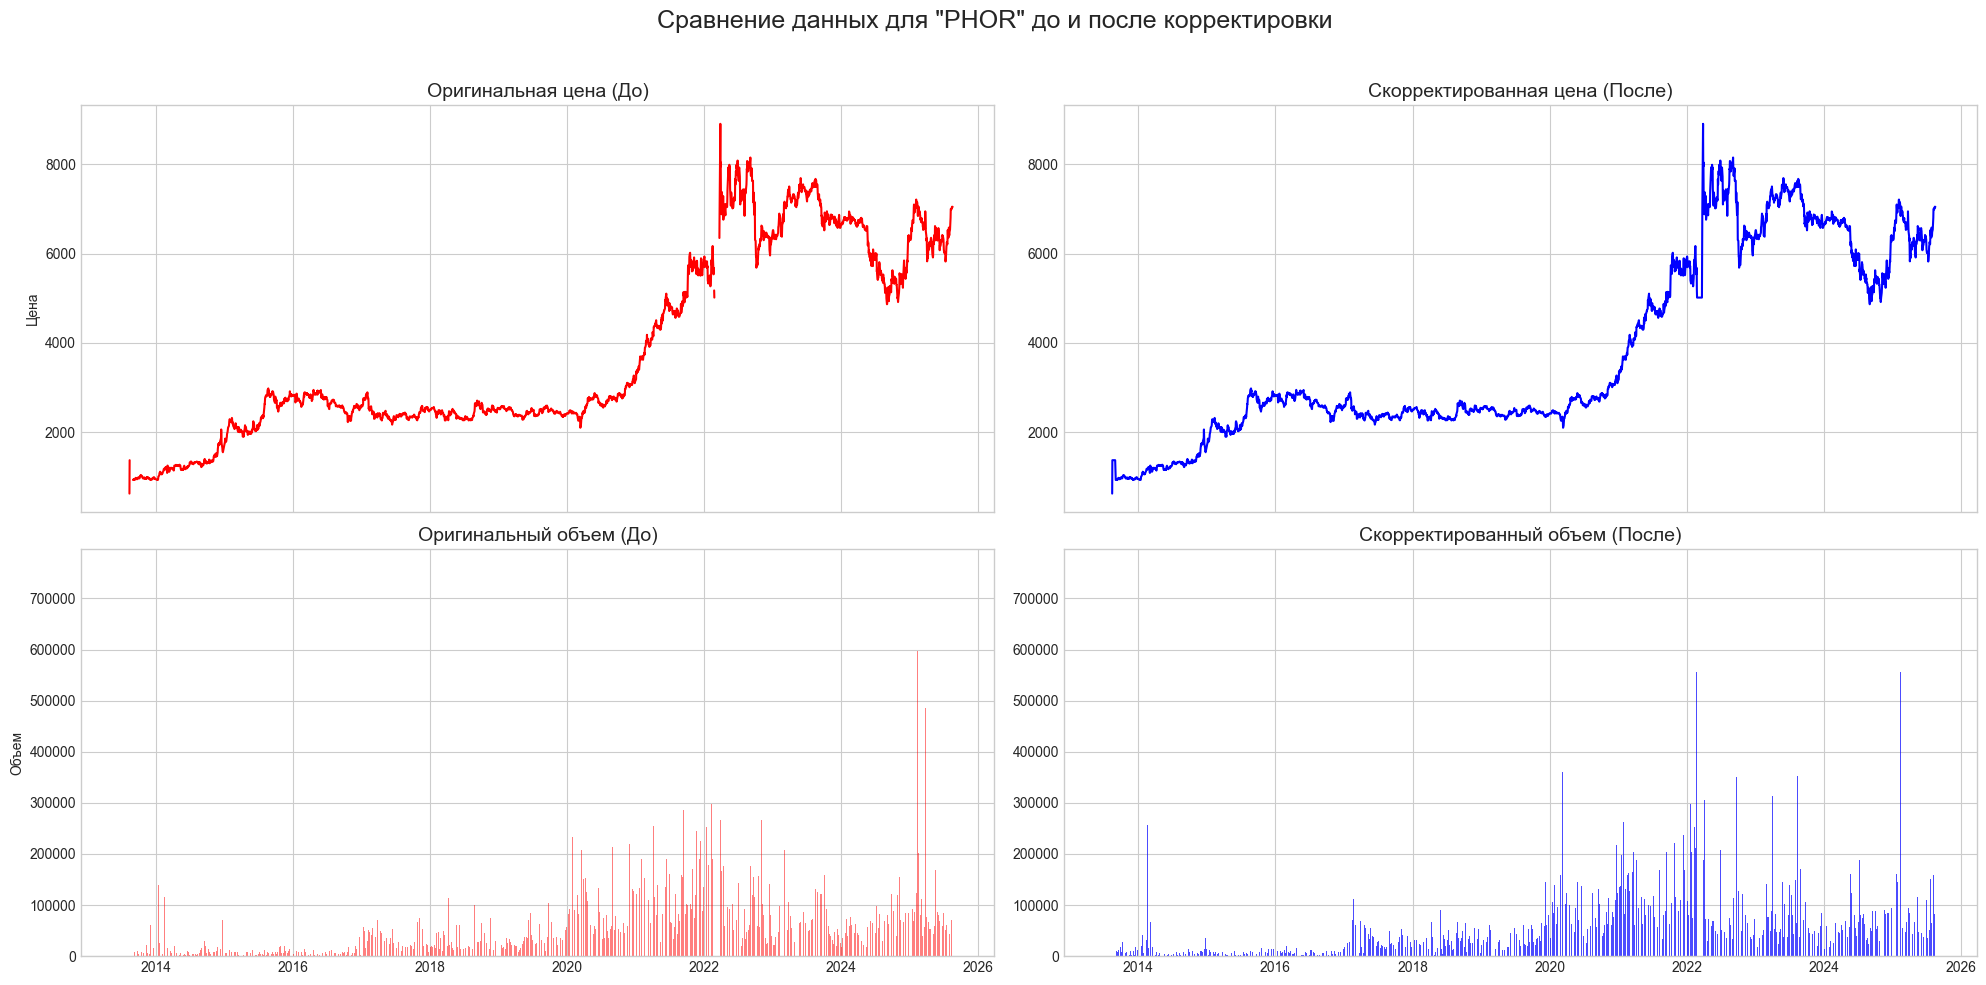


Отрисовка графиков для тикера 'AFKS'...


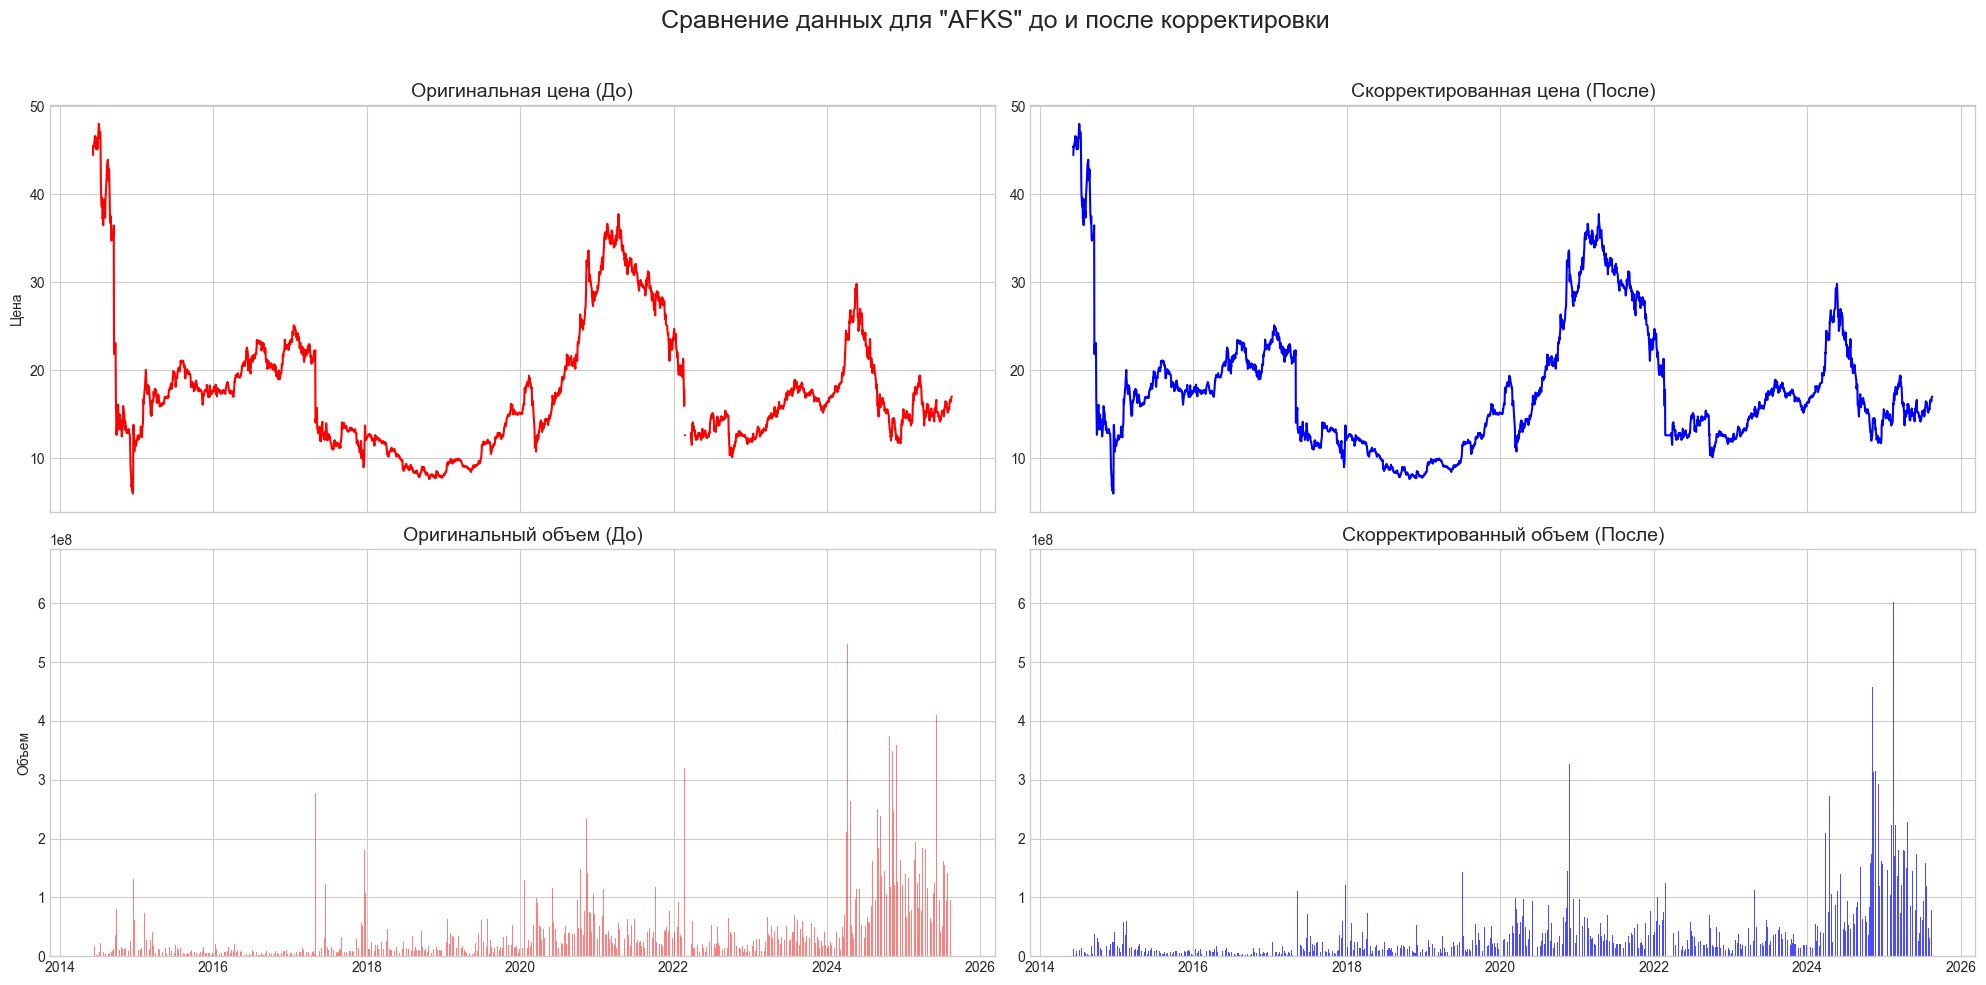


Отрисовка графиков для тикера 'IRAO'...


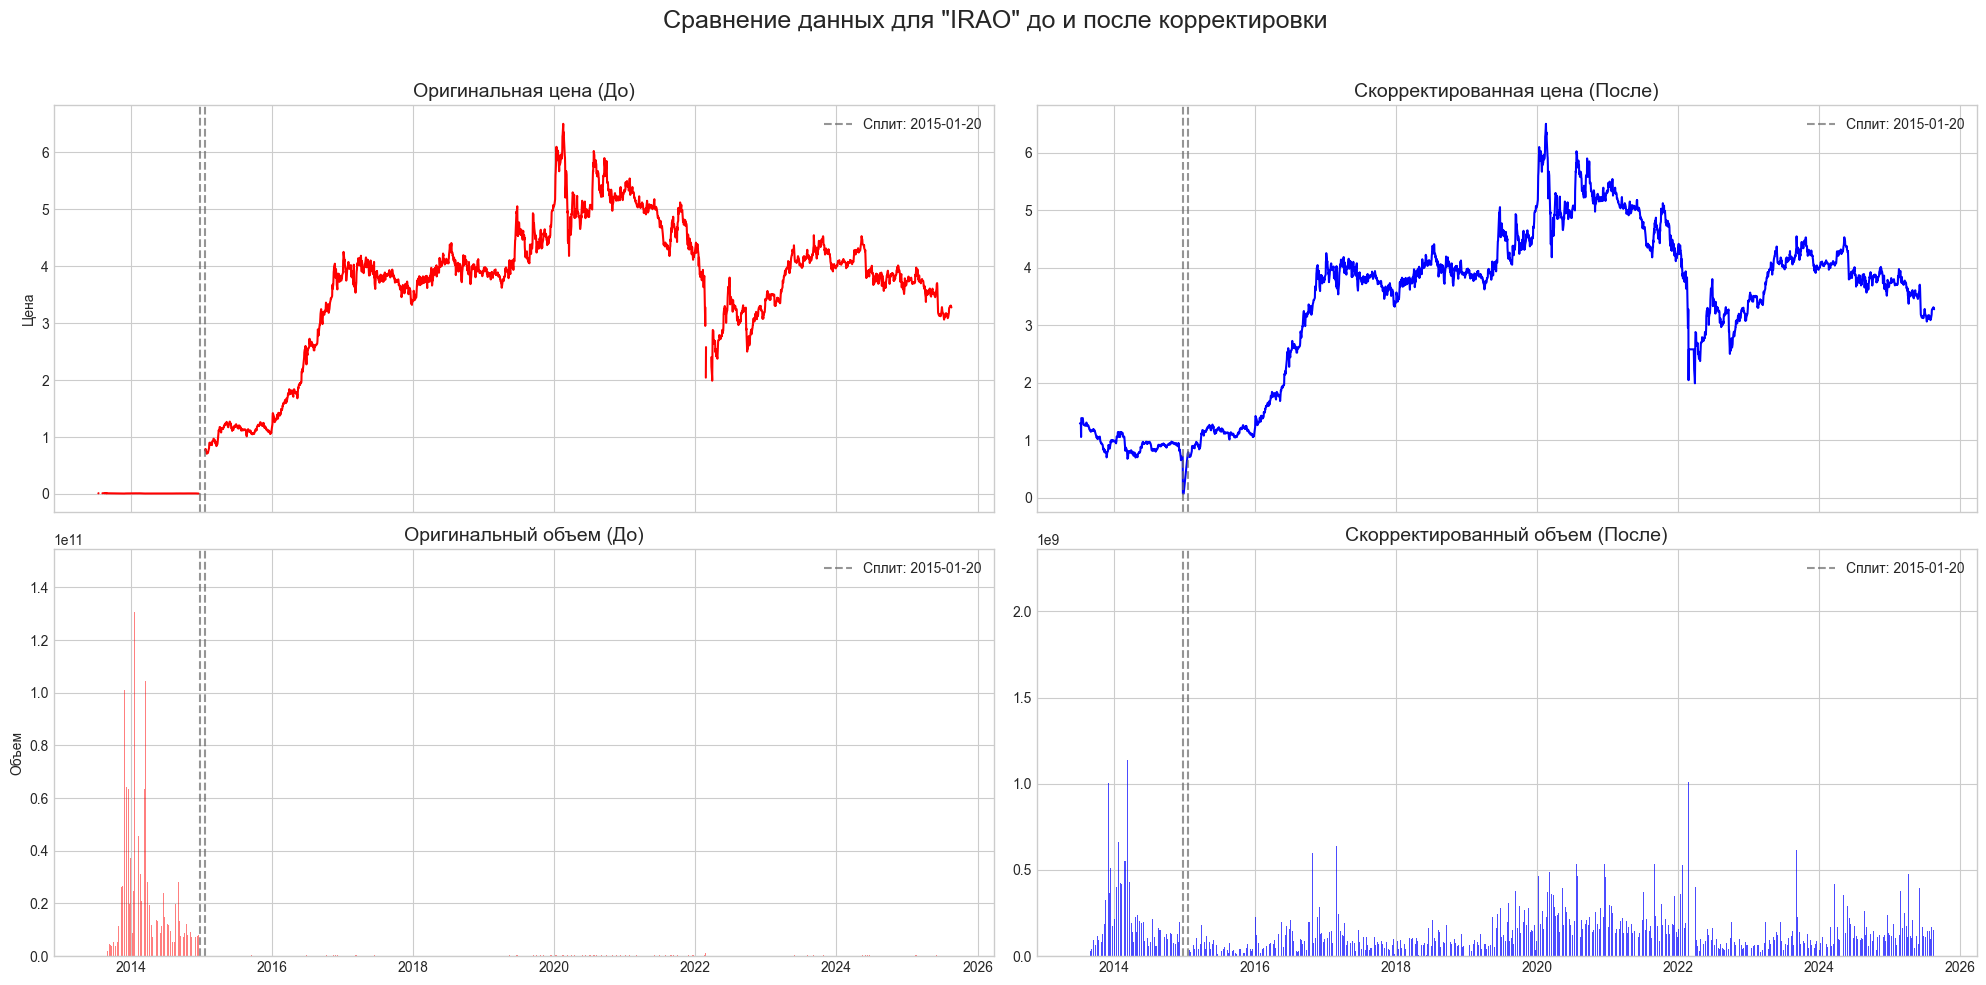


Отрисовка графиков для тикера 'SELG'...


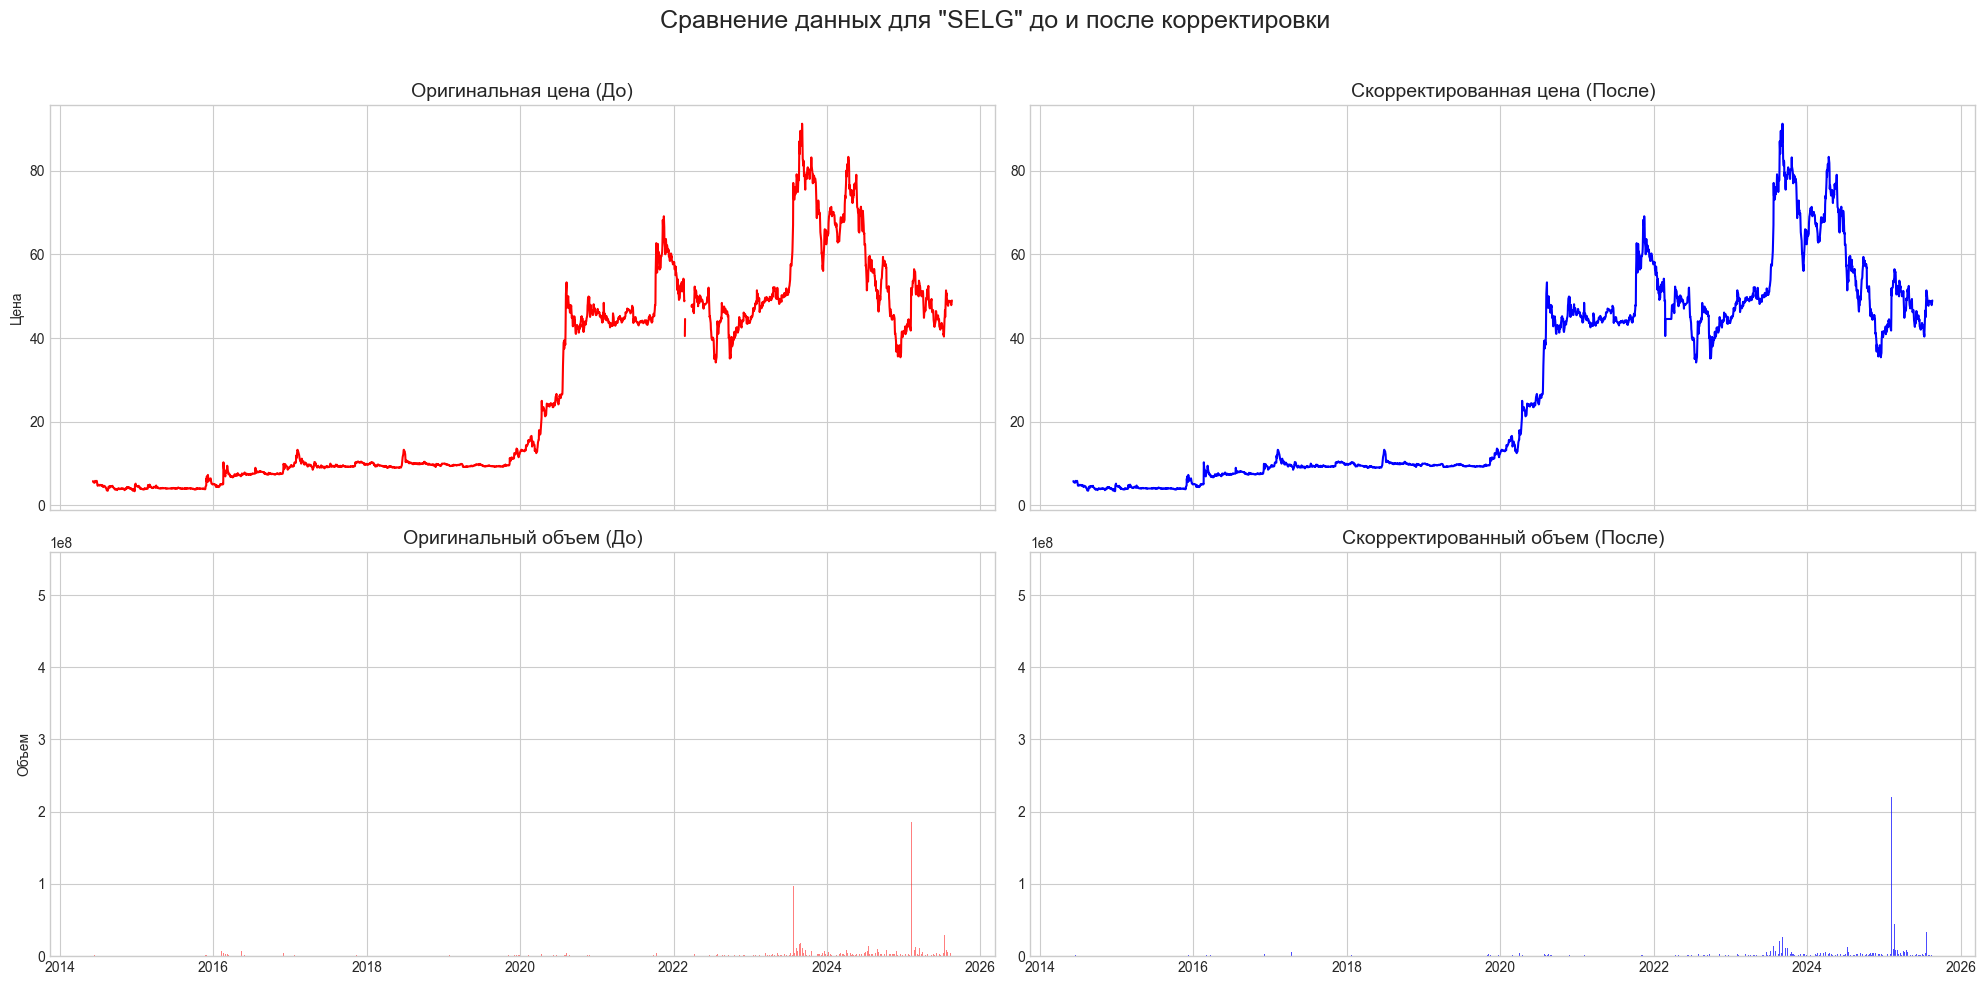


Отрисовка графиков для тикера 'TRNFP'...


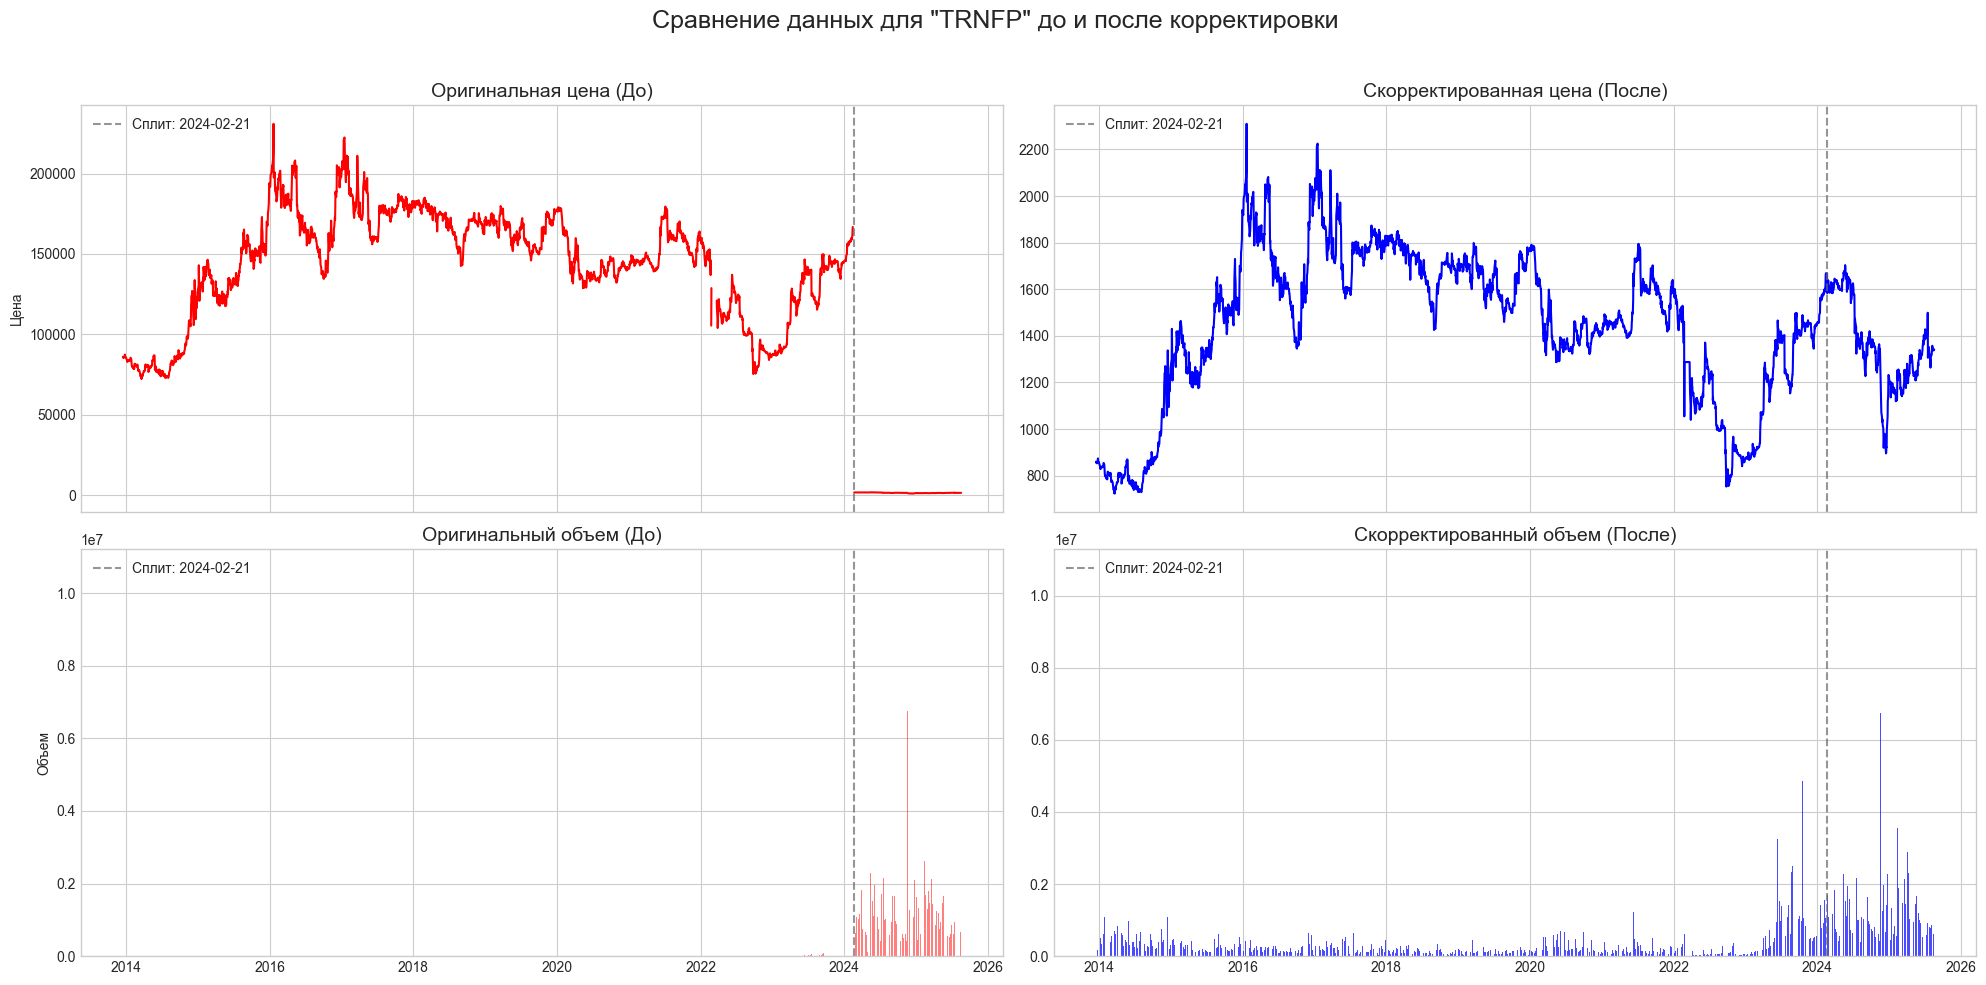


Отрисовка графиков для тикера 'VTBR'...


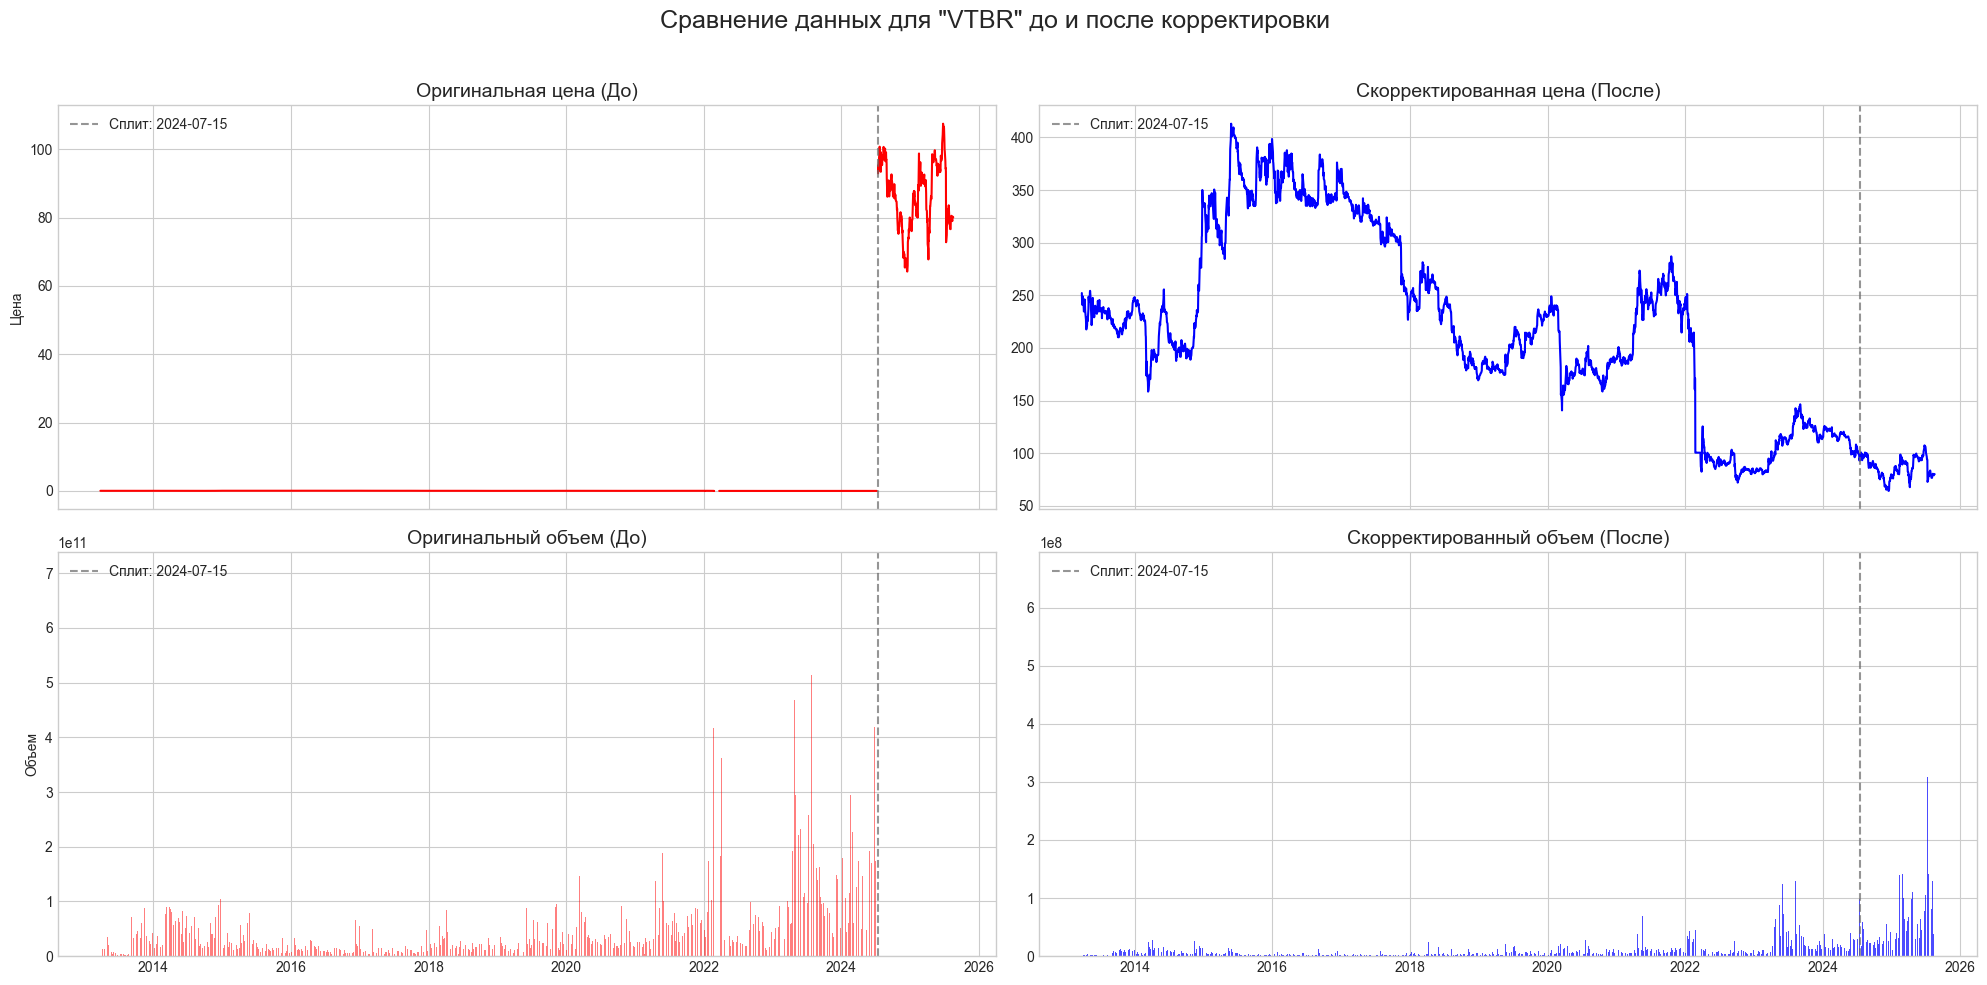


Сохранение: ../data/moex_normalized_data.csv
Нормализованные данные успешно сохранены!


In [15]:
# ==============================================================================
# ОСНОВНОЙ СКРИПТ
# ==============================================================================

data_folder = "../data/"
data_filename = 'moex_data_with_external.csv'
normalized_data_filename = 'moex_normalized_data.csv'

config_folder = "config/"
split_map_filename = os.path.join(config_folder, "splits.json")


SPLIT_THRESHOLD = 0.99

# --- Загрузка и заполнение пропусков ---
print(f"Загрузка: {data_folder + data_filename}")
raw_df = pd.read_csv(data_folder + data_filename, parse_dates=['Date'])

print("\nЗаполнение внутренних пропусков (NaN)...")
df_filled = raw_df.groupby('Ticker', group_keys=False).apply(lambda x: x.apply(fill_internal_na))

# --- ЭТАП 1: ДИАГНОСТИКА ---
print("\n--- ЭТАП 1: Первичная диагностика аномалий на сырых данных ---")
split_candidates = find_large_returns(df_filled.copy(), SPLIT_THRESHOLD)
if split_candidates is not None:
    print("\nНайдены следующие кандидаты для добавления в 'create_split_map':")
    print(split_candidates.to_string())
else:
    print("На сырых данных аномалий не найдено.")

# --- ЭТАП 2: КОРРЕКТИРОВКА ---
manual_split_map = load_split_map(split_map_filename)
normalized_df = adjust_prices_from_map(df_filled.copy(), manual_split_map)

# --- ЭТАП 3: ВЕРИФИКАЦИЯ ---
print("\n--- ЭТАП 3: Повторная диагностика на скорректированных данных ---")
remaining_anomalies = find_large_returns(normalized_df.copy(), SPLIT_THRESHOLD)
if remaining_anomalies is not None:
    print("\nВНИМАНИЕ! После корректировки остались следующие аномалии:")
    print(remaining_anomalies.to_string())
else:
    print("Проверка пройдена: после корректировки аномалий не осталось.")

# --- ЭТАП 4: ВИЗУАЛИЗАЦИЯ ---
for i in split_candidates.Ticker:
    print(f"\nОтрисовка графиков для тикера '{i}'...")
    plot_before_after_comparison(normalized_df, raw_df, i, manual_split_map)


# --- ЭТАП 5: СОХРАНЕНИЕ ---
print(f"\nСохранение: {data_folder + normalized_data_filename}")
normalized_df.to_csv(data_folder + normalized_data_filename, index=False)
print("Нормализованные данные успешно сохранены!")


Отрисовка детального ('zoomed') графика для 'IRAO'...


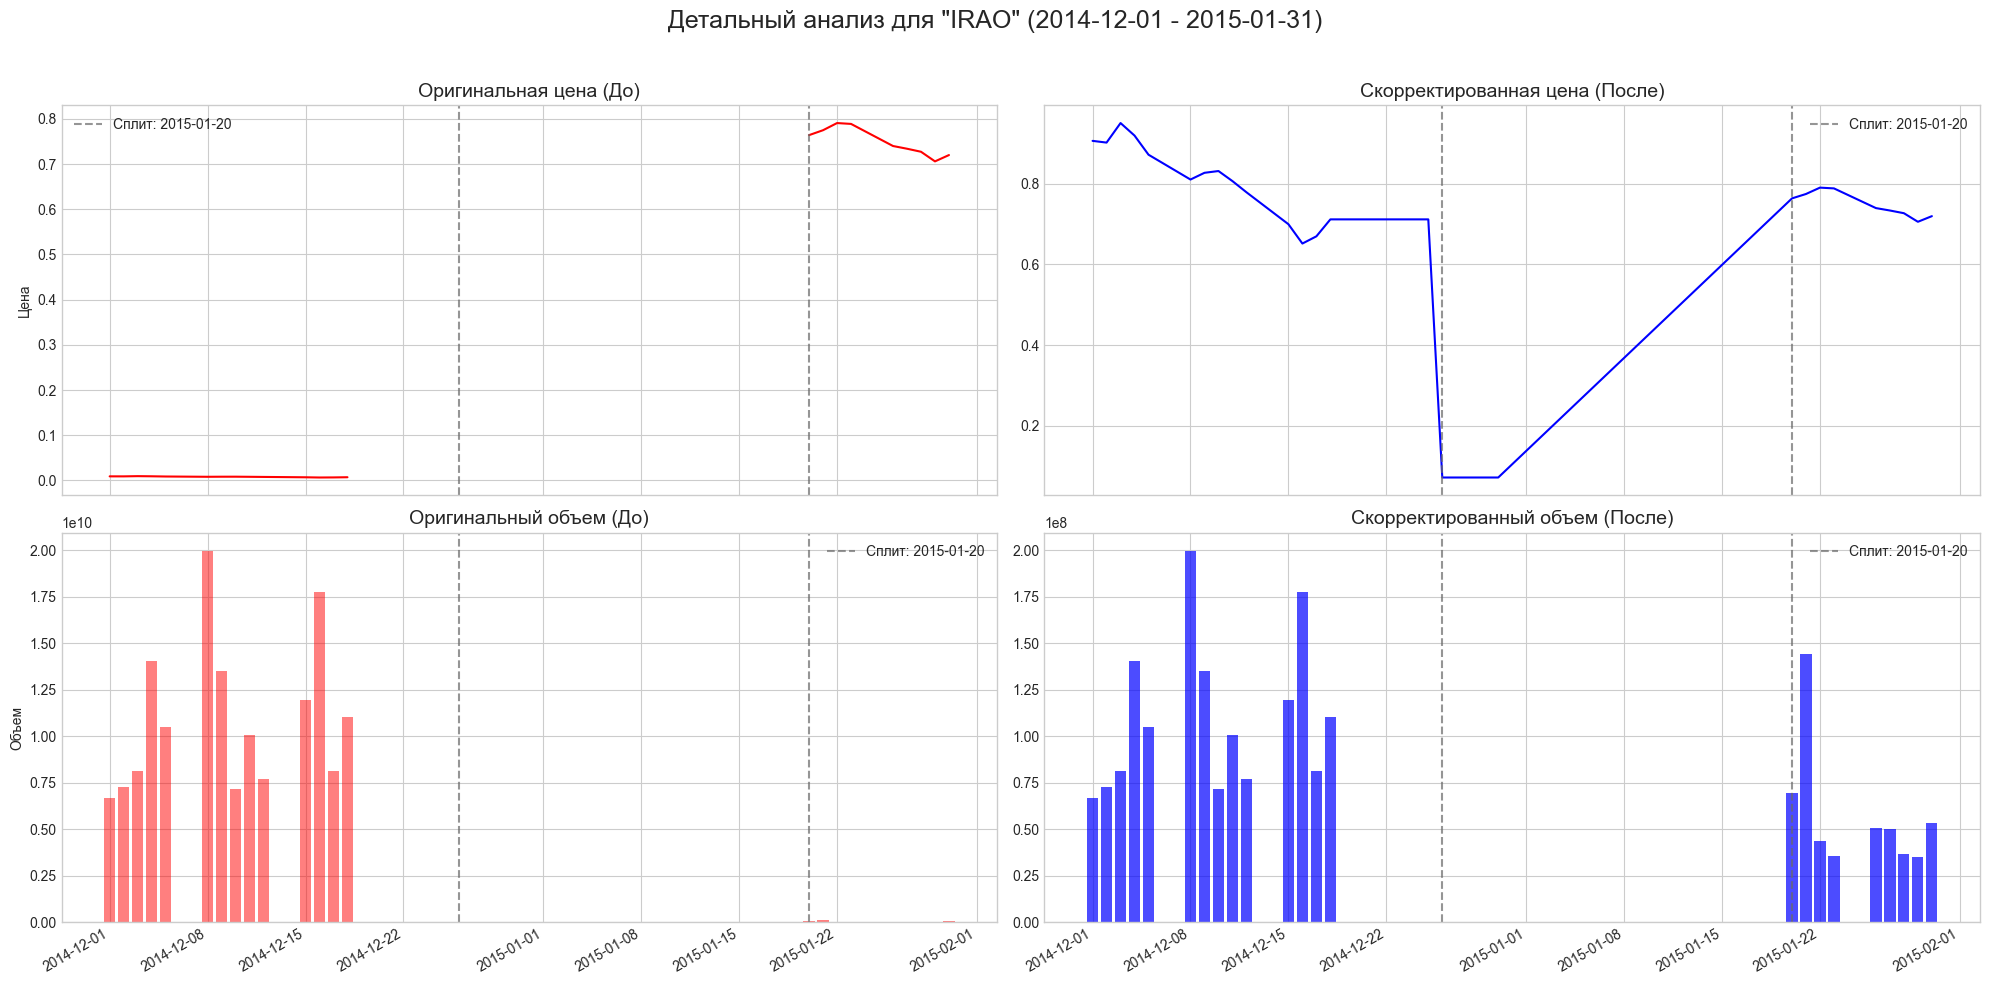

In [16]:


# --- ЭТАП 4.5: Детальный анализ (Zoom) ---
# Измените эти параметры для детального анализа другого периода или тикера
TICKER_TO_ZOOM = 'IRAO'
ZOOM_START_DATE = '2014-12-01'
ZOOM_END_DATE = '2015-01-31'



print(f"\nОтрисовка детального ('zoomed') графика для '{TICKER_TO_ZOOM}'...")
plot_zoomed_comparison(
    df_adj=normalized_df,
    df_orig=raw_df,
    ticker=TICKER_TO_ZOOM,
    start_date=ZOOM_START_DATE,
    end_date=ZOOM_END_DATE,
    split_map=manual_split_map
)


